In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv('final_data.csv')

In [10]:
data = raw_data.copy()
total_instances = data.shape[0]

In [11]:
# remove inf
plottable_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["funding_velocity"], how="all")
data = plottable_data

In [12]:
def plot_categorical(category, dataset=data, numeric_feature='funding_velocity'):
    plt.figure(figsize=(15,8))
    count = round(dataset.groupby([category])[numeric_feature].mean().sort_values(ascending=False), 2)
    sns.barplot(count.values, count.index, )
    for i, v in enumerate(count.values):
        plt.text(0.8,i,v,color='k',fontsize=12)
    plt.xlabel(numeric_feature, fontsize=20)
    plt.ylabel(category, fontsize=20)
    plt.show()

## Approach

When determining what categories are important for our model, we will consider two main things:

1. How rare is this category? Keeping extremely rare categories will add unecesary dimensionality and potentially cause overfitting. We'll set the threshold for how common categories need to be to be considered significant at 2%.

2. How much does this category tell me that my other features don't? If we already have another feature with a similar relationship to the label class, it's less important to keep.

## Activities

In [13]:
alpha = 0.02

In [14]:
for activity in data["activity"].sample(100):
    counts = data[data["activity"] == activity]["sector"].value_counts()
    if (len(counts) != 1): 
        print("More than one associated sector")

We can see that each activity is related to exactly one sector, or in other words, activities are direct subcategories of sector.

Let's see if there are any levels for `activity` in which the average velocity of the instances within that level is very different from the average velocities of the instances in that level's associated sector.

In [15]:
# get average velocities for each category
s_velocity = data.groupby(['sector'])['funding_velocity'].mean()
a_velocity = data.groupby(['activity'])['funding_velocity'].mean()
activity_counts = data.activity.value_counts()

In [16]:
# find activities that are highly distinct from associated sector
distinct = pd.DataFrame()

for activity in data.activity.value_counts().index.values:
    # get associated sector
    sector = data[data["activity"] == activity]["sector"].values[0]
    # check if the average velocity for sector is very different from activity
    variation =  a_velocity[activity] - s_velocity[sector]
    if abs(variation) > 3:
        distinct = distinct.append(
            {"activity": activity, 
            "sector": sector, 
            "variation" : variation,
            "count" : activity_counts[activity]},
            ignore_index=True)
        
print("Num instances at a level to consider that level significant: " + str(round(total_instances * alpha)))
print()
print(distinct)

Num instances at a level to consider that level significant: 9418

                          activity   count         sector   variation
0   Primary/secondary school costs  3009.0      Education   -4.829989
1               Education provider  2878.0      Education    5.203340
2        Personal Medical Expenses  2458.0         Health   -3.403891
3                       Embroidery  1983.0           Arts   -3.994440
4                         Hardware   749.0         Retail    4.343838
5                       Used Shoes   604.0       Clothing    5.504562
6                Natural Medicines   500.0         Health    4.890419
7                         Textiles   448.0           Arts    6.115519
8                           Health   409.0         Health    4.665626
9                         Printing   317.0       Services   11.296186
10                       Bookstore   312.0         Retail    6.213100
11       Renewable Energy Products   287.0         Retail   25.292051
12                     

We can see that there are some cases of variation between activity velocity and that activity's asoiciated sector velocity, but in the cases with high variation, the number of features belonging to that category is too small to justify adding the feature to our dataset.

With little significant variation in activity, we will assume that using sector as our only feature is fine. Let's take a closer look at sector.

## Sector

In [17]:
sectors = data.sector.value_counts().index.values
print(len(sectors))

15


/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


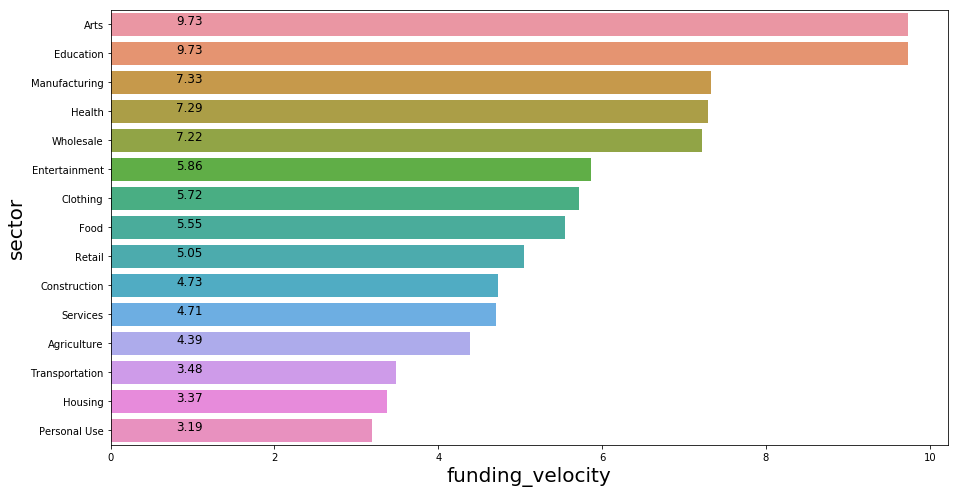

In [18]:
plot_categorical("sector")

In [19]:
total_instances = data.shape[0]
insig = []

for s in sectors:
    freq = len(data[data["sector"] == s])
    percent = (freq / total_instances)
    if percent < alpha:
        insig.append(s)
        
print(len(insig))

6


/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


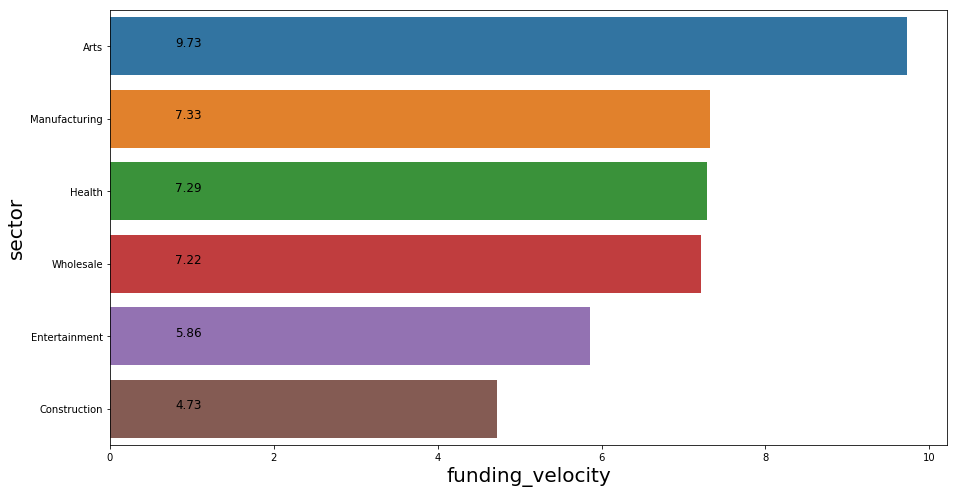

In [20]:
plot_categorical("sector", data.loc[data['sector'].isin(insig)])

Let's simplify these into two categories.

In [21]:
replacements = {}

for sector in insig:
    if s_velocity[sector] > 6:
        replacements[sector] = "low"
    else:
        replacements[sector] = "high"
        
data = data.replace({"sector" : replacements})
data.sector.value_counts()

Agriculture       130678
Food               99112
Retail             95027
Personal Use       29113
Services           28305
Clothing           21089
Housing            17673
low                17067
Education          15464
Transportation     12084
high                4196
Name: sector, dtype: int64

## Loan Themes

In [22]:
themes = data.loan_theme_type.value_counts().index.values
print(len(themes))

110


As before, lets start by finding how many categories occur frequently enough to be considered as unique categories.

In [23]:
total_instances = data.shape[0]

sig = []
insig = []

for t in themes:
    freq = len(data[data["loan_theme_type"] == t])
    percent = (freq / total_instances)
    if percent > alpha:
        sig.append(t)
    else:
        insig.append(t)
        
print(sig)

['General', 'Underserved', 'Agriculture', 'Water', 'Rural Inclusion', 'General (Women)']


Only 6 categories fit enough data to be considered without grouping, with one being 'general'.

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


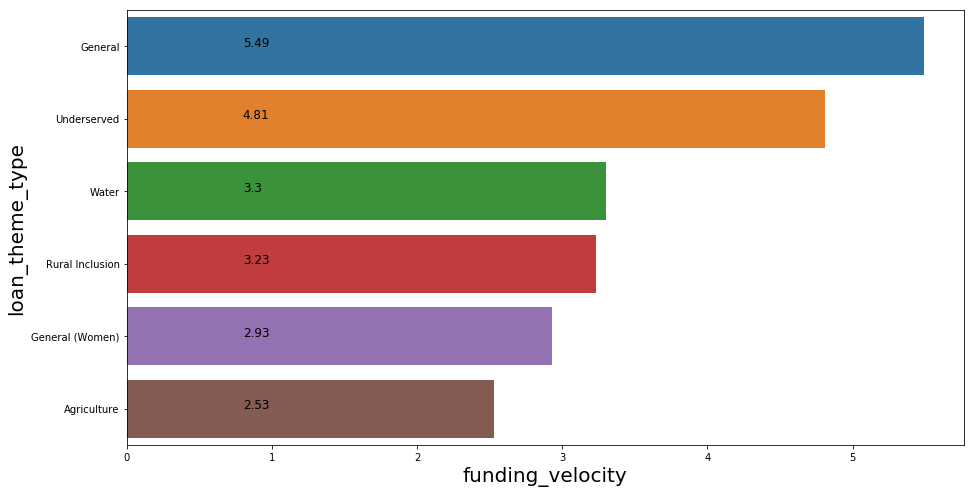

In [24]:
# plot velocity for most for significant
significant = data.loc[data['loan_theme_type'].isin(sig)]

plot_categorical('loan_theme_type', significant)

Now that we know what categories are present enough to be significant, let's look at how much the values in these significant categories differ from the values in their associated `sector` for their relationship to our label, `funding_velocity.`

In [25]:
for theme in sig:
    print(theme.upper())
    counts = data[data["loan_theme_type"] == theme]["sector"].value_counts()
    counts = counts[counts > total_instances * 0.01]
    print(counts)
    print()

GENERAL
Retail            77428
Food              77255
Agriculture       59098
Services          16634
Clothing          15323
low                9935
Transportation     7851
Housing            6512
Name: sector, dtype: int64

UNDERSERVED
Retail         6988
Food           6722
Agriculture    5283
Name: sector, dtype: int64

AGRICULTURE
Agriculture    23776
Name: sector, dtype: int64

WATER
Personal Use    14523
Name: sector, dtype: int64

RURAL INCLUSION
Agriculture    7327
Name: sector, dtype: int64

GENERAL (WOMEN)
Series([], Name: sector, dtype: int64)



We can see that, apart from general, most of our significant themes relate closely to one of our sectors. Undeserved is the one exception to this rule. Let's take a closer look at that.

In [26]:
avg_for_theme = data.groupby(['sector', 'loan_theme_type']).mean()
avg_for_theme.sort_index(inplace=True)

retail_avg = avg_for_theme.loc[('Retail', 'Underserved')]["funding_velocity"]
food_avg = avg_for_theme.loc[('Food', 'Underserved')]["funding_velocity"]
agr_avg = avg_for_theme.loc[('Agriculture', 'Underserved')]["funding_velocity"]

avg = data.groupby(['sector'])["funding_velocity"].mean()

print(abs(avg["Retail"] - retail_avg))
print(abs(avg["Food"] - food_avg))
print(abs(avg["Agriculture"] - agr_avg))

1.2892471906122411
0.17302638319726515
3.9821045188375193


We can see that instances belonging to the category `undereserved` do not have much of a deviation from the average of their associated sector in their relationship to `funding_velocity.` This leads us to assume that it may not be too important to include along with our `sector` feature.

Based on this analysis, we will not lose a lot of information by excluding the `loan_theme_type` category. This category is not worth the dimensionality it adds.

## Countries

In [27]:
insig_countries = []

countries = data.country.value_counts().index.values

for c in countries:
    freq = len(data[data["country"] == c])
    percent = (freq / total_instances)
    if percent < alpha:
        insig_countries.append(c)
        
print(len(insig_countries))

43


/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


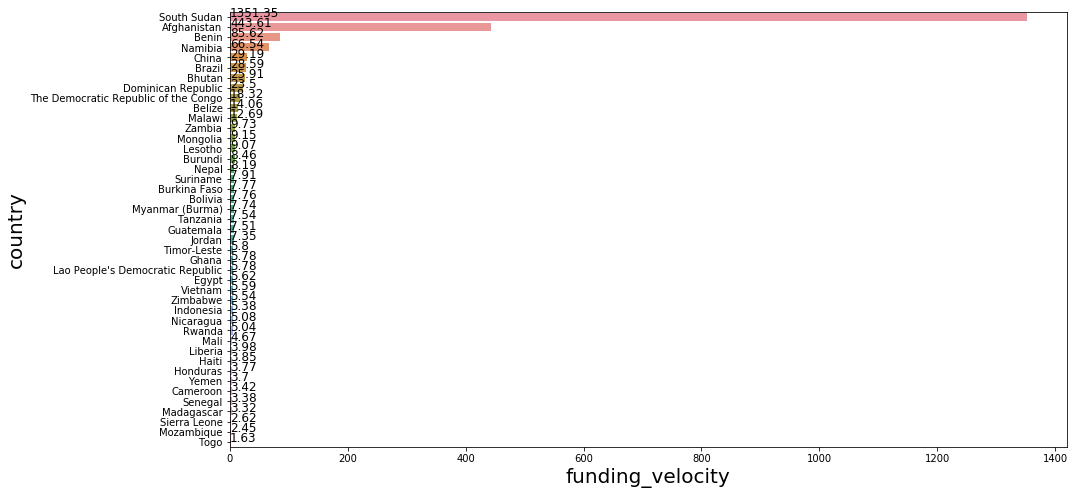

In [28]:
# plot velocity for most for insignificant
insignificant = data.loc[data['country'].isin(insig_countries)]

plot_categorical('country', insignificant)

In [29]:
country_avgs = data.groupby(['country'])['funding_velocity'].mean()
region_avgs = data.groupby(['world_region'])['funding_velocity'].mean()
country_counts = data.country.value_counts()

for country in insig_countries:
    count = country_counts[country]
    c_avg = country_avgs[country]
    region = data[data["country"] == country]["world_region"].iloc[0]
    r_avg = region_avgs[region]
    if((abs(c_avg - r_avg) * count) > (total_instances * alpha * 2)):
        print(country.upper() + " with average: " + str(c_avg))
        print(region + ": " + str(r_avg))
        print(count)
        print()
        insig_countries.remove(country)

NICARAGUA with average: 5.075951934492223
Latin America and Caribbean: 7.972147177130518
8635

HONDURAS with average: 3.7733083133921514
Latin America and Caribbean: 7.972147177130518
5025

THE DEMOCRATIC REPUBLIC OF THE CONGO with average: 18.322196809555788
Sub-Saharan Africa: 3.7564169678230885
2963



These few countries have significant deviation in their relation to our label from the average in their world region, and encompass a reasonable percent of the dataset. Based on this logic, we'll move them to the "significant" list.

Now lets simplify the rest of the countries by their world region.

In [30]:
replacements = {}

for country in insig_countries:
    replacements[country] = data[data["country"] == country]["world_region"].iloc[0]
        
data = data.replace({"country" : replacements})
data.country.value_counts()

Philippines                             149517
Kenya                                    63349
Sub-Saharan Africa                       39359
Cambodia                                 32497
Pakistan                                 26487
Uganda                                   19101
Tajikistan                               19016
Latin America and Caribbean              17238
El Salvador                              15752
Peru                                     15295
East Asia and the Pacific                14268
Colombia                                 13541
Ecuador                                  10978
Nigeria                                   9971
Nicaragua                                 8635
Arab States                               6113
Honduras                                  5025
The Democratic Republic of the Congo      2963
South Asia                                 703
Name: country, dtype: int64

We are ending up with a couple levels with very rare occurences, but we know those levels are distinct either geographically (South Asia) or in their relationship with the label (Congo), so I hesitate to further combine them.

/Users/mariah/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


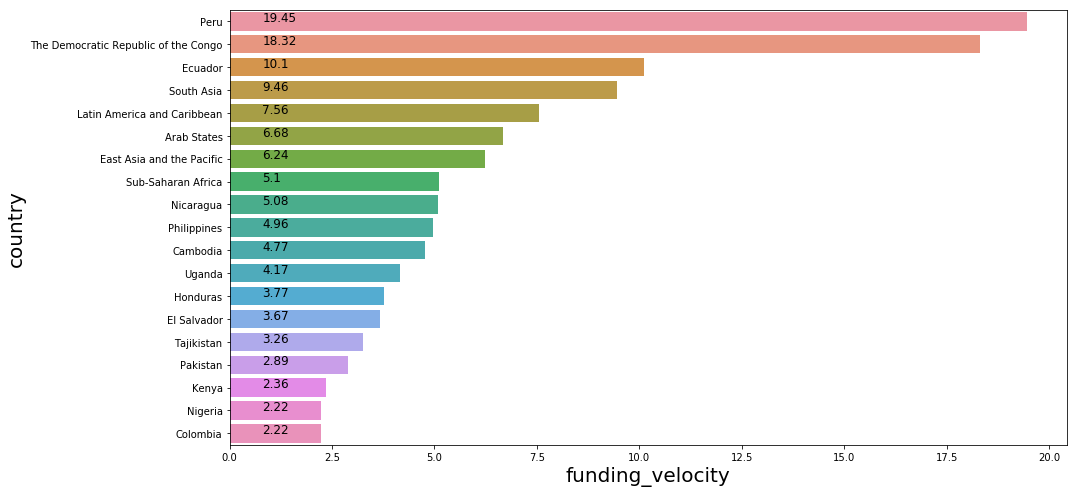

In [31]:
plot_categorical("country", dataset=data)

## Dummification & Dropping

In [32]:
data.drop(['activity', 'loan_theme_type', 'repayment_interval'], axis=1, inplace=True)

In [33]:
data = pd.get_dummies(data, columns=["country", "sector"], drop_first=True)

In [34]:
data

,Unnamed: 0,id,funded_amount,loan_amount,region,currency,partner_id,posted_time,disbursed_time,term_in_months,...,sector_Clothing,sector_Education,sector_Food,sector_Housing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_high,sector_low
0,0,653053,575.0,575.0,Lahore,PKR,247.0,2014-01-01 06:51:08,2013-12-17 08:00:00,11.0,...,0,0,0,0,0,0,0,1,0,0
1,1,653063,200.0,200.0,Lahore,PKR,247.0,2014-01-01 08:03:11,2013-12-24 08:00:00,11.0,...,0,0,0,0,0,0,0,0,0,1
2,2,653084,400.0,400.0,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19,2013-12-17 08:00:00,14.0,...,0,0,1,0,0,0,0,0,0,0
3,3,653078,400.0,400.0,Ellahabad,PKR,245.0,2014-01-01 11:46:01,2013-12-20 08:00:00,14.0,...,0,0,0,0,0,0,1,0,0,0
4,4,653082,475.0,475.0,Lahore,PKR,245.0,2014-01-01 11:49:43,2013-12-20 08:00:00,14.0,...,0,0,0,0,0,0,0,0,0,1
5,5,653060,200.0,200.0,Lahore,PKR,247.0,2014-01-01 07:32:39,2013-12-24 08:00:00,11.0,...,0,0,0,0,0,0,0,1,0,0
6,6,653088,400.0,400.0,Faisalabad,PKR,245.0,2014-01-01 12:03:43,2013-12-16 08:00:00,14.0,...,0,0,0,0,0,0,0,0,0,1
7,7,653089,400.0,400.0,Faisalabad,PKR,245.0,2014-01-01 12:04:57,2013-12-24 08:00:00,14.0,...,0,0,0,0,0,1,0,0,0,0
8,8,653062,400.0,400.0,Lahore,PKR,247.0,2014-01-01 07:57:58,2013-12-24 08:00:00,12.0,...,1,0,0,0,0,0,0,0,0,0
9,10,653054,300.0,300.0,Lahore,PKR,247.0,2014-01-01 06:58:07,2013-12-17 08:00:00,11.0,...,0,0,0,0,0,0,0,1,0,0
